---
**License**

 cmp_cluster_ccl_numcosmo

 Wen Aug 07 15:11:00 2024\
 Copyright  2024\
 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>
 Mariana Penna-Lima     <pennalima@gmail.com> \
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 cmp_cluster_ccl_numcosmo\
 Copyright (C) 2021 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

<a class="anchor" id="contents"></a>
# Contents

### 1. [Packages](#libraries)
### 2. [Cosmological models](#constants)
### 3. [Proxy modeling](#proxy)
####     3.1 [Relative error plot](#proxy_plots)
### 4. [Halo mass function](#mass)
### 5. [Unbinned approach](#unbinned)
####     5.1 [Mock catalog](#mock)
####     5.2 [NumCosmo predictions](#numcosmo_ubinned)
####     5.3 [CCL preditictios](#ccl_unbinned)
####     5.4 [Relative error plots](#plots_unbinned)
### 6. [Binned approach](#binned)
####     6.1 [Bins](#bins)
####     6.2 [NumCosmo predictions](#numcosmo_binned)
####     6.3 [CCL preditictios](#ccl_binned)
####     6.4 [Relative error plots](#plots_binned)

<a class="anchor" id="libraries"></a>
## 1.  [Packages](#libraries)
***

In the cell below, we import the libraries `CCL` and `NumCosmo` for comparison between their cluster counts predictions in an unbinned and binned with a richness-proxy.

To import `NumCosmo`, we should import `GObject`. This is important because `GObject` help us to maps the C language in other languages, like python.

The package `sys` is related to the manipulation and obtaining information from the python environment imports the auxiliary library `CLCosmo_Sim` to run the binned counts version of `CCL`. The package `numpy` help us with the calculations, gives us access to mathematical functions, while astropy is used too handle the fits files for the cluster mock catalog.


In [1]:
#!/usr/bin/env python
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.ccl import nc_ccl

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table




import pyccl as ccl
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import sys
sys.path.insert(0,'../../../CLCosmo_Sim/modeling/')
sys.path.insert(0,'../../../CLCosmo_Sim/modeling/old_files/')
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_cluster_abundance as cl_count
import old_CL_COUNT_class_cluster_abundance as old_cl_count
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import time

<a class="anchor" id="constants"></a>
## 2. [Cosmological models](#constants)
***
In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.265 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.0448 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 71.00   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$\sigma_{8}$ = 0.80 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>


In [11]:
# CCL cosmology default paramters
cosmo_ccl_default = ccl.Cosmology(Omega_c=0.265, Omega_b=0.0448, h=0.71, sigma8=0.8, n_s=0.96, Omega_k=0, transfer_function="eisenstein_hu",)


# CCL cosmology high precision paramters
ccl_params = nc_ccl.CCLParams()
ccl_params.set_high_prec_params()

cosmo_ccl_high = ccl.Cosmology(Omega_c=0.265, Omega_b=0.0448, h=0.71, sigma8=0.8, n_s=0.96, Omega_k=0, transfer_function="eisenstein_hu",)

#NumCosmo Cosmology
cosmo_numcosmo, dist, ps_lin, ps_nln, psf = nc_ccl.create_nc_obj(cosmo_ccl_default)

<a class="anchor" id="constants"></a>
## 2. [Proxy model](#constants)
***
In this cell below we fix the mass observable relation given by

$$
P(\log\lambda|M,z) = N(\mu(M,z), \sigma^2(M,z))
$$
the mean is
$$
    \mu(M,z) = \mu_0 + \mu_M\log_{10}\frac{M}{M_0} + \mu_z\log_{10}\frac{1+z}{1+z_0} 
$$
variance is
$$
\sigma(M,z) = \sigma_0 + \sigma_M\log_{10}\frac{M}{M_0} + \sigma_z\log_{10}\frac{1+z}{1+z_0} 
$$

With parameters given by
$\mu_{0}$ = 3.091<br>
$\mu_{M}$ = 2.4177<br>
$\mu_{z}$ = 0.0<br>

$\sigma_{0}$ = 0.594<br>
$\sigma_{M}$ = 0.05987<br>
$\sigma_{z}$ = 0.0<br>
and pivot mass and redshift

$M_{0}$ = 1e14.2<br>
$z_{0}$ = 0.4<br>


In [3]:
#CCL proxy model
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]




# Numcosmo_proxy model
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

cluster_m = Nc.ClusterMassAscaso(lnRichness_min=0.0, lnRichness_max=np.log(700) , z0=0.4 , M0 =10**14.2)
cluster_m.param_set_by_name("mup0", 3.091)
cluster_m.param_set_by_name("mup1", 1.05)
cluster_m.param_set_by_name("mup2", 0.0)
cluster_m.param_set_by_name("sigmap0", 0.594)
cluster_m.param_set_by_name("sigmap1", 0.026)
cluster_m.param_set_by_name("sigmap2", 0)

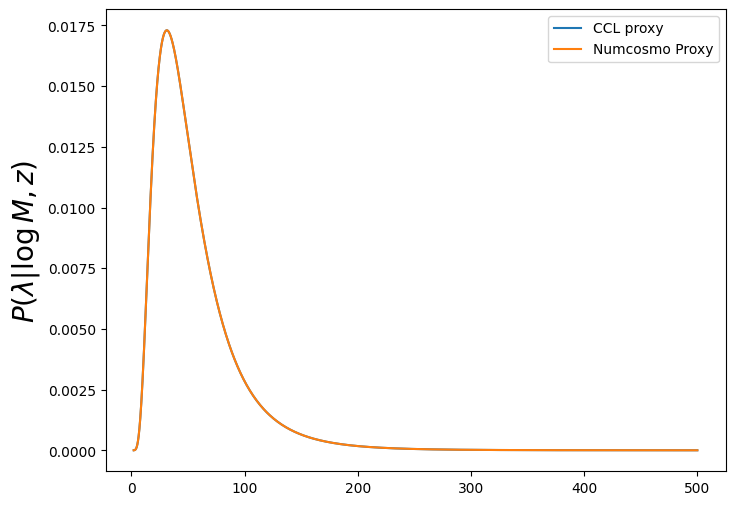

Text(0, 0.5, '$|P_{Num} - P_{CCL}|$')

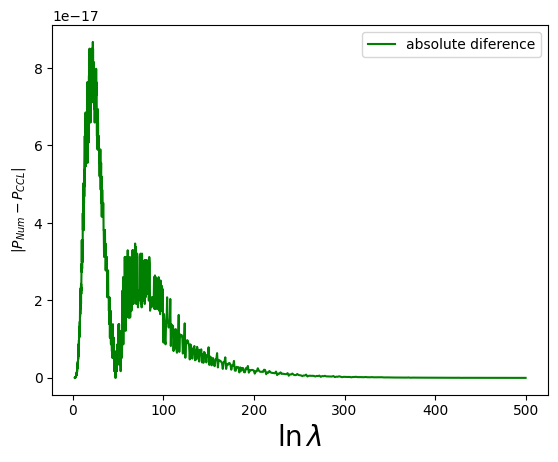

In [4]:
proxy_array = np.linspace(np.log(2), np.log(500), 1000)
proxy10_array = np.logspace(np.log10(2), np.log10(500), 1000)
z = 0.5
logM = np.log(10) * np.log10(10**(14.5))
pdf_clusterm_numcosmo = []
diff = []
for lnrichness in range(len(proxy_array)):
    pdf_clusterm_numcosmo.append(cluster_m.p(cosmo_numcosmo, logM, z, [proxy_array[lnrichness]], None)/(np.exp(proxy_array[lnrichness])))
    diff.append(abs(cluster_m.p(cosmo_numcosmo, logM, z, [proxy_array[lnrichness]], None)/np.exp(proxy_array[lnrichness]) - 
                rm_relation.pdf_richness_mass_relation(proxy10_array, 14.5, z, theta_rm)[lnrichness]))


fig1 = plt.figure(figsize=(8, 6))
plt.plot(proxy10_array,  rm_relation.pdf_richness_mass_relation(proxy10_array, 14.5, z, theta_rm), label="CCL proxy")
plt.plot(proxy10_array, pdf_clusterm_numcosmo, label="Numcosmo Proxy")
plt.legend()
plt.ylabel(r"$P(\lambda|\log M, z)$", fontsize=20)
plt.show()

frame2 = fig1.add_axes((0.1, 0.1, 0.8, 0.2))
plt.plot(proxy10_array, diff, c="g", label="absolute diference")
plt.legend()
plt.xlabel(r"$\ln \lambda$", fontsize=20)
plt.ylabel(r"$|P_{Num} - P_{CCL}|$", fontsize=10)

<a class="anchor" id="mass"></a>
## 4.  [Halo Mass Function](#mass)
***
In the cell above we initialize the halo mass function objects in both `NumCosmo` and `CCL`

In [5]:
sky_area = 5264.05 * (np.pi / 180) ** 2


mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)

hmf_numcosmo = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf_numcosmo.set_area(sky_area)

ca = Nc.ClusterAbundance.new(hmf_numcosmo, None)

mset = Ncm.MSet.new_array([cosmo_numcosmo, cluster_m, cluster_z])
mset.pretty_log()
print("sigma8 = " + str(cosmo_numcosmo.sigma8(psf)))


# CCL halo mass funtion
massdef = ccl.halos.massdef.MassDef(200, "critical")
hmd = ccl.halos.hmfunc.MassFuncTinker08(mass_def=massdef)

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.265               [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7255              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.044               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

<a class="anchor" id="unbinned"></a>
## 5.  [Unbinned approach](#unbinned)
***
In the cells above we compute

$$
x_i = \int_{\log_{10}M_{min}}^{\log_{10}M_{min}}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M,z_i)}{d\log_{10}M}P(\lambda_i|M,z_i)d\log_{10}M
$$

<a class="anchor" id="mock"></a>
### 5.1 [Mock catalog](#mock)

In the cell below we created a the mock catalog to compare the predictions in the unbinned case

In [6]:
# Generates cluster count catalog data
ncdata = Nc.DataClusterNCount.new(ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
rng = Ncm.RNG.pool_get("example_ca_sampling")
ncdata.init_from_sampling(mset, sky_area, rng)
ncdata.catalog_save("ca_ascaso_unbinned_numcosmo.fits", True)

ncdata_fits = fits.open("ca_ascaso_unbinned_numcosmo.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort("Z_TRUE")

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.001900252390442583,1.7772047388295968,0.001900252390442583,30.914815447313956
0.0022496852139460557,0.8041419749709758,0.0022496852139460557,30.74150701667652
0.003291023327279388,0.366802921732712,0.003291023327279388,29.94486823768091
0.003306900097891742,0.5993288418950476,0.003306900097891742,30.670150727361467
0.0053421390146509325,1.4550044101585669,0.0053421390146509325,30.088770032191416
0.005446012950210867,2.90766727300798,0.005446012950210867,31.842687307669497
0.005454241192466682,1.3494645113547659,0.005454241192466682,31.266456609084656
0.0070476065458995605,0.42490565147040493,0.0070476065458995605,30.26335111917985
0.007944628745680037,1.078173055343659,0.007944628745680037,30.25923792864631


<a class="anchor" id="numcosmo_ubinned"></a>
### 5.2 [NumCosmo predictions](#numcosmo_ubinned)

In [7]:
# Using Numcosmo
t0 = time.time()

ca.prepare(cosmo_numcosmo, cluster_z, cluster_m)
dndproxy_numcosmo = []
for richness_i in range(len(ncdata_Table[0][:])):
    dndproxy_numcosmo.append(
        ca.lnM_p_d2n(
            cosmo_numcosmo,
            cluster_z,
            cluster_m,
            [ncdata_Table[richness_i][1]],
            None,
            ncdata_Table[richness_i][0],
        )
    )
t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 0.0004162788391113281


<a class="anchor" id="ccl_ubinned"></a>
### 5.3 [CCL predictions](#ccl_ubinned)

In [ ]:
# Using CCL
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(11, 16, 30)
z_grid = np.linspace(.1, 1, 301)

bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':False, 'compute_purity':False }

t0 = time.time()


t1 = time.time()
print("time (seconds) = " + str(t1 - t0))


<a class="anchor" id="plots_unbinned"></a>
### 5.4 [Relative error plots](#plots_unbinned)

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(
    ncdata_Table[0][:],
    100
    * abs(np.array(dndproxy_numcosmo) - np.array(dndproxy_exact_CCL))
    / np.array(dndproxy_numcosmo),
    s=20,
    c=ncdata_Table[1][:],
    cmap="viridis",
)
plt.colorbar()
plt.xlabel("redshift", fontsize=20)
plt.ylabel("|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.yscale("log")
plt.ylim(1e-6, 1e-1)
plt.grid(True, which="both")

<a class="anchor" id="binned"></a>
## 5.  [Binned approach](#binned)
***

Compute the integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}P(\lambda|M,z)d\log_{10}M
$$

<a class="anchor" id="mass"></a>
### 5.1 [Bins](#bins)

In the cell below we created the bins to compare the predictions in the binned case


In [8]:
# Bins definition
def binning(nodes): return [[nodes[i],nodes[i+1]] for i in range(len(nodes)-1)]
z_edges = np.linspace(0.1, 1, 4)
Z_bin = binning(z_edges)
logrichness_edges = np.linspace(np.log(20), np.log(200), 5)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 5))
Richness_bin = binning(richness_edges)

In [9]:
# Using CCL
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(11, 16, 30)
z_grid = np.linspace(.1, 1, 301)


t0 = time.time()
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':None, 'params_completeness': None, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo_ccl_default, 'halo_mass_distribution': hmd}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':False, 'compute_purity':False }

count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
integrand_count_default = cl_count.define_count_integrand(count_modelling_new, adds)




t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

t0 = time.time()
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':None, 'params_completeness': None, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo_ccl_high, 'halo_mass_distribution': hmd}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':False, 'compute_purity':False }

count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
integrand_count_high = cl_count.define_count_integrand(count_modelling_new, adds)




t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 0.42832422256469727
time (seconds) = 27.02368426322937


In [24]:
# Using Numcosmo

t0 = time.time()
ca.prepare(cosmo_numcosmo, cluster_z, cluster_m)
N_proxy_numcosmo = []


for rich_l, rich_u in zip(logrichness_edges, logrichness_edges[1:]):
    N_zbin = []
    for zl, zu in zip(z_edges, z_edges[1:]):
        N_zbin.append(
            ca.intp_bin_d2n(
                cosmo_numcosmo,
                cluster_z,
                cluster_m,
                [rich_l],
                [rich_u],
                None,
                [zl],
                [zu],
                None,
            )
        )

    N_proxy_numcosmo.append(N_zbin)

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 0.04285454750061035


<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5626/3706076166.py:17: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel("|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
/tmp/ipykernel_5626/3706076166.py:17: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel("|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)


NameError: name 'proxy_edges' is not defined

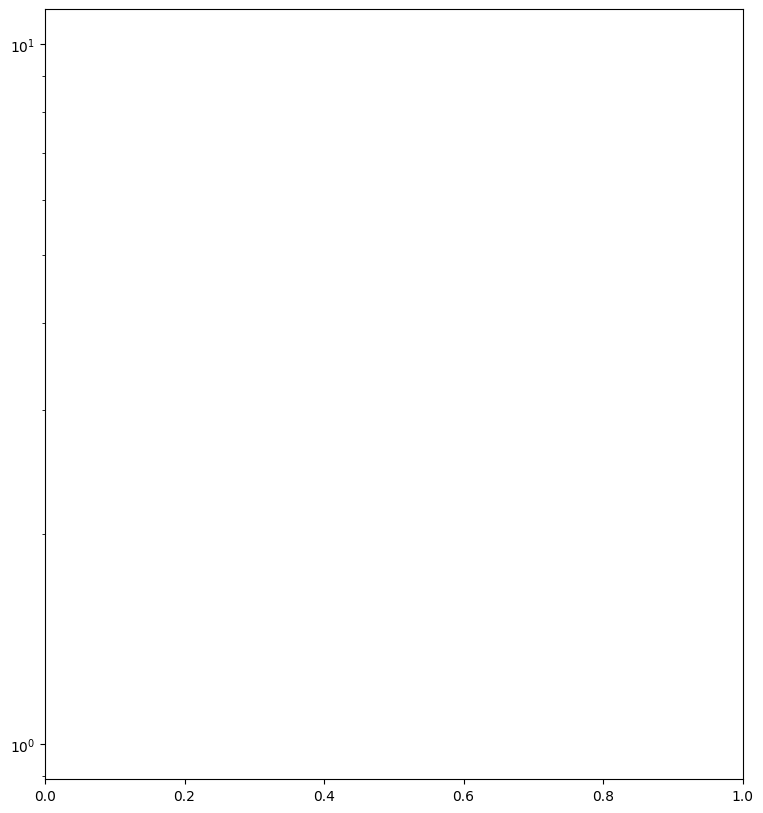

In [10]:
plt.figure(figsize=(9, 10))
plt.yscale("log")
z_ = [np.mean([z_edges[i], z_edges[i + 1]]) for i in np.arange(len(z_edges) - 1)]
proxy = [
    np.mean([proxy_edges[i], proxy_edges[i + 1]])
    for i in np.arange(len(proxy_edges) - 1)
]


plt.tick_params(axis="both", which="both", labelsize=15)
for f in range(len(proxy_edges) - 1):
    if f == 0:
        label = []
    y_simps = abs(100 * (1 - N_ProxyZ_exact[:, f] / N_proxy_numcosmo[:][f]))
    plt.scatter(z_, y_simps, label=str(f + 1) + " richness bin")
plt.grid(True, which="both")
plt.ylabel("|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.ylim(1e-7, 1e-1)
plt.xlabel(r"$redshift$", fontsize=20)
plt.legend(frameon=False, fontsize=20)